In [1]:
import warnings
warnings.filterwarnings('ignore')

import shap
from acv_explainers import ACVTree
from acv_explainers.utils import *
from experiments.exp_linear_gmm import *

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns

import random 
import numpy as np
import pandas as pd

random.seed(212)
np.random.seed(212)

# 1- DEMO CLASSIFIER

##  How to compute SDP, $S^\star$, Shapley values based on $S^\star$, Global SDP

### Load data and model

In [4]:
X = pd.read_csv('/home/samoukou/Documents/ACV/data/lucas0_train.csv')
X.head()

y = X.Lung_cancer.values
X.drop(['Lung_cancer'], axis=1, inplace=True)

num_features = X.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Model 
tree = DecisionTreeClassifier(min_samples_leaf=20, random_state=212)
tree.fit(X_train, y_train)

accuracy_train = roc_auc_score(y_train, tree.predict_proba(X_train)[:, 1])
accuracy_test = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
print('[* TREE *]')
print('train acc = {} --- test acc = {}'.format(accuracy_train, accuracy_test))

forest = RandomForestClassifier(n_estimators=10, min_samples_leaf=2, random_state=212)
forest.fit(X_train, y_train)
forest.estimators_[0] = tree

accuracy_train = roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])
accuracy_test = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
print('[* FOREST *]')
print('train acc = {} --- test acc = {}'.format(accuracy_train, accuracy_test))

[* TREE *]
train acc = 0.9230919439227646 --- test acc = 0.9127666666666667
[* FOREST *]
train acc = 0.9410099722217437 --- test acc = 0.9072


### Build ACVTree for explanations

In [5]:
acvtree = ACVTree(forest, X_train.values)

### Let's choose an observation to explain

In [6]:
idx = 267
ind = X_train.values[idx]
y_ind = y_train[idx]
fx = forest.predict(np.expand_dims(ind, 0))[0]

In [7]:
X_train[idx:idx+1]

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing
1690,0,0,0,0,0,0,1,1,0,0,0


In [8]:
print('f(x) = {}, y_ind = {}'.format(fx, y_ind))

f(x) = 0, y_ind = 0


### SDP(x, f) of Smoking, Genetics ?

In [9]:
var = ['Smoking', 'Genetics']
columns_names = [X.columns[i] for i in range(X.shape[1])]
id_var = [i for i in range(X.shape[1]) if X.columns[i] in var]

# params init
algo = 'plugin'
threshold = 0.9
data = X_train.values

sdp = acvtree.compute_sdp_clf(x=ind, fx=fx, tx=threshold, S=id_var, data=data)
print('SDP(x, f) of variable = {} is {}'.format(var, sdp))

SDP(x, f) of variable = ['Smoking', 'Genetics'] is 0.7227001064598163


### Compute $S^\star$ ?

In [10]:
# params init 

sdp_cluster = []
threshold = 0.5
proba = 0.95
decay = 0.77
index = list(range(X.shape[1]))
algo = 'plugin'
data = X_train.values

acvtree.compute_local_sdp_clf(ind, fx, threshold, proba, index, data, sdp_cluster, decay, verbose=0, C=[[5, 6]])

print('Cluster find by SDP = {}'.format(sdp_cluster))

sdp_importance = []
for c in sdp_cluster:
    value = [acvtree.compute_sdp_clf(ind, fx, threshold, S=chain_l(c), 
             data=data) for i in range(len(forest.estimators_))]

    sdp_importance.append(np.mean(value))

sdp_importance

sdp_importance_name = []
for c in sdp_cluster:
    sdp_importance_name.append(str([X.columns[i] for i in c]))

Cluster find by SDP = [[0, 4, 10], [1, 2, 3, 7, 8, 9, 5, 6]]


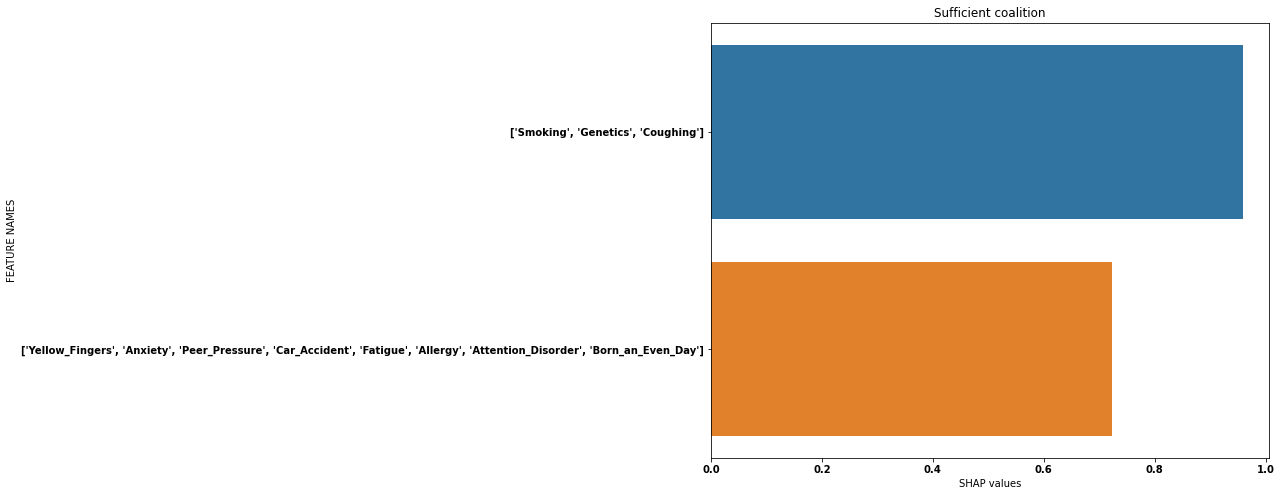

In [11]:
plt.rcParams["font.weight"] = "bold"
plot_feature_importance(sdp_importance, sdp_importance_name, 'forest_SDP  ', title='Sufficient coalition')

### Compute Shapley values based on $S^\star$ ?

In [12]:
C = [[]]
bad_coal = sdp_cluster[-1]
sufficient_coal = sdp_cluster[0]
forest_sh_acv = acvtree.shap_values_acv(x=np.expand_dims(ind, 0), C=C, N_star=bad_coal,
                        S_star=sufficient_coal)

100%|██████████| 151/151 [00:00<00:00, 576.62it/s]


<Figure size 1800x1200 with 0 Axes>

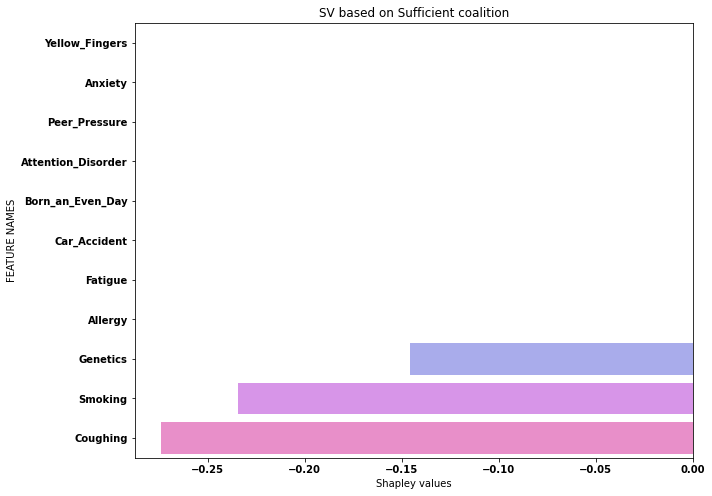

In [13]:
forest_shf_acv = np.mean(forest_sh_acv, 0)
forest_shf_acv = forest_shf_acv[:, 1]

plt.figure(dpi=300)
plot_feature_importance(forest_shf_acv, columns_names, 'shap value based on SDP Coalition ', 'Shapley values', title='SV based on Sufficient coalition')

### Global SDP when Y = 0 (LONG RUNNING TIME $\approx$ 2H)

In [13]:
sdp_importance_m, sdp_importance, sdp_importance_proba, sdp_importance_coal_count, sdp_importance_variable_count\
= acvtree.global_sdp_importance_clf(data=X_test.values[y_test<1], data_bground=X_train.values, columns_names=columns_names, 
                            global_proba=0.9, decay=0.7, threshold=0.6, proba=0.9, C=C, verbose=0)

100%|██████████| 100/100 [2:40:31<00:00, 96.31s/it]  


<Figure size 1800x1200 with 0 Axes>

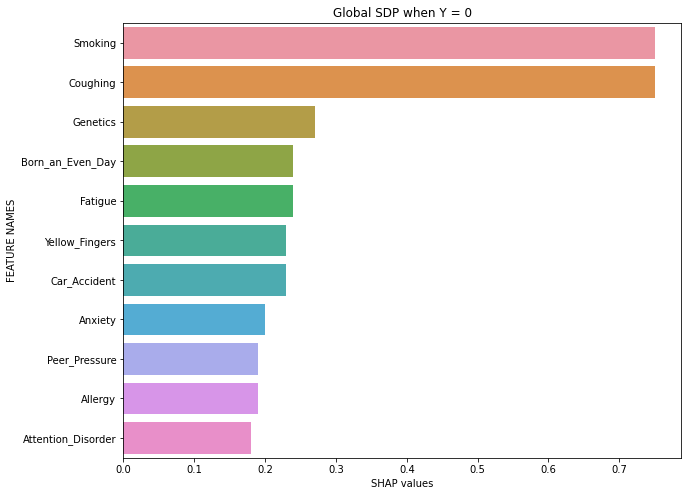

In [14]:
plt.figure(dpi=300)
plot_feature_importance(list(sdp_importance_variable_count.values()), columns_names, 'global sdp  ', title='Global SDP when Y = 0')

<Figure size 1800x1200 with 0 Axes>

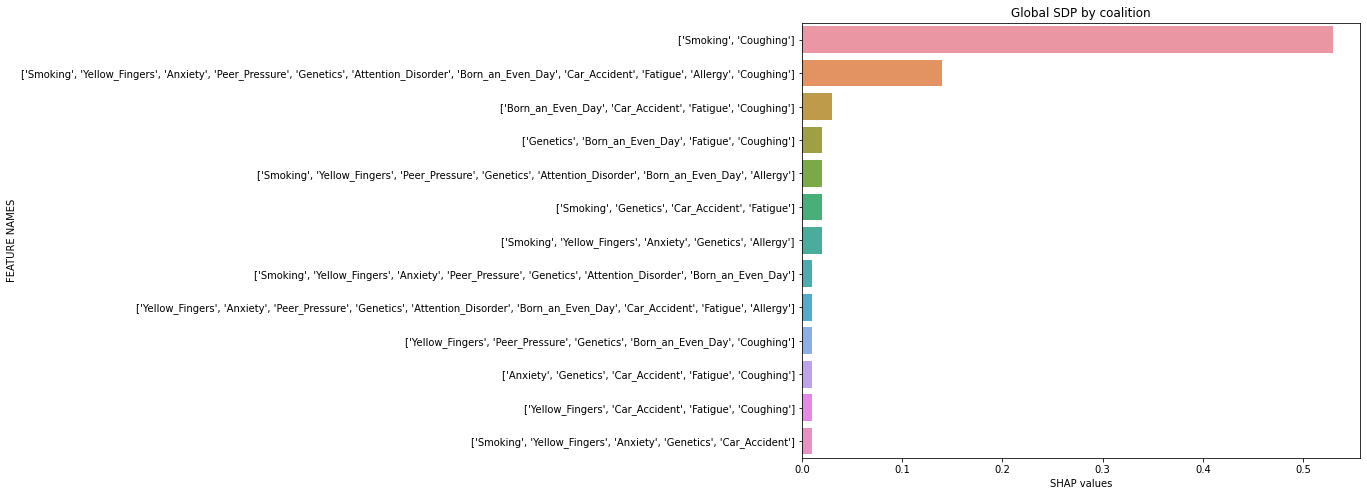

In [15]:
plt.figure(dpi=300)
plot_feature_importance(list(sdp_importance_coal_count.values()), list(sdp_importance_coal_count.keys()), 'global sdp  ',
                       title='Global SDP by coalition')

# 2- Demo regression: Linear GMM

##  How to compute SDP, $S^\star$, Shapley values based on $S^\star$

###  Load data and model 

In [14]:
import random
random.seed(2021)

np.random.seed(2021)

In [15]:
from experiments.exp_linear_gmm import *

In [16]:
# p = 0.7
n = 20000
d = 5

for i in range(5):
    cov = {}
    gaus = np.random.randn(d, d)
    cov['a'] = np.dot(gaus, gaus.T)
    gaus = np.random.randn(d, d)
    cov['b'] = np.dot(gaus, gaus.T)
    gaus = np.random.randn(d, d)
    cov['c'] = np.dot(gaus, gaus.T)


    exp = ExperimentsLinearGMM(mean={'a': [0., 0., 0., 0., 0.], 'b': [0., 0., 0., 0., 0.], 'c': [0., 0., 0., 0., 0.]},
                               cov=cov,
                               coefs={'a': [9, 5, -8, 0, 0], 'b': [0, 0, -6, -8, -9], 'c': [4, 9, 13, 0, 0]},
                               pi={'a': 1/3, 'b': 1/3, 'c': 1/3}, n=n, C=[[5, 6]],
                               cat_index=[5, 6])

tree = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=10, max_depth=20, random_state=2021)
tree = exp.fit_model(tree)

fitted model train_error = 8.643123435721925
fitted model test_error = 26.407572675565177


In [17]:
seed = np.random.randint(0, 10000)
forest = RandomForestRegressor(n_estimators=1, min_samples_leaf=1, min_samples_split=2, max_depth=15, random_state=7706)
forest = exp.fit_model(forest)

forest.estimators_[0] = tree

fitted model train_error = 12.731731079407764
fitted model test_error = 32.90399400680125


In [18]:
idx = 156
ind = exp.data_test[idx]
y_ind = exp.y_test[idx]

fx = forest.predict(np.expand_dims(ind, 0))[0]

In [19]:
print('x = {}'.format(ind))

x = [ 2.0601348   2.00732006 -0.90904155 -1.91465107 -3.7068906   1.
  0.        ]


In [20]:
fx = forest.predict(np.expand_dims(ind, 0))[0]
print('f(x) = {}, y = {}'.format(fx, y_ind))

f(x) = 32.09369634481081, y = 35.850145862612564


In [21]:
print('----------------------TRAIN-------------------------------------------------------------------------------')
m, q9, q0 = ecart_model(tree, exp.data, exp.y_train)
print(' ')
print('----------------------TEST--------------------------------------------------------------------------------')
m, q9, q0 = ecart_model(tree, exp.data_test, exp.y_test)

----------------------TRAIN-------------------------------------------------------------------------------
mse = 8.643123435721925 -- max = 918.8833853473327 -- min = 6.993741383114843e-08 -- q0.95 = 34.79151162174762 -- q0.25 2.015023435505177
 
----------------------TEST--------------------------------------------------------------------------------
mse = 26.407572675565177 -- max = 5395.291825123236 -- min = 2.8345716341141897e-08 -- q0.95 = 103.00214117736857 -- q0.25 6.552596789152577


# Build ACVTree for explanation

In [22]:
acvtree = ACVTree(forest, exp.data)

### Compute SDP for all coalition $S \subset [0, \dots, d ]$ 

In [23]:
index = list(exp.index) + [[5, 6]]
s_index = len(index)
c_value = {i:{} for i in range(s_index + 1)}
i_best, c_best = {i: 100 for i in range(s_index + 1)}, {i: 100 for i in range(s_index + 1)}
data = exp.data
N = 10000

print('--------------- f_hat(ind) = {} ------------'.format(fx))
for size in tqdm(range(len(index) + 1)):
    for c in itertools.combinations(index, size):
        if len(c) != 0 and len(c) != len(index):
            
            value = acvtree.compute_sdp_reg(x=ind, fx=fx, tx=10, S=chain_l(c), data=data)
            
            if len(c) == 1:
                nam = 'X{}'.format(c[0]).replace('X[5, 6]', 'Y')
            elif len(c) == 2:
                nam = 'X{}, X{}'.format(c[0], c[1]).replace('X[5, 6]', 'Y')
            elif len(c) == 3:
                nam = 'X{}, X{}, X{}'.format(c[0], c[1], c[2]).replace('X[5, 6]', 'Y')
            elif len(c) == 4:
                nam = 'X{}, X{}, X{}, X{}'.format(c[0], c[1], c[2], c[3]).replace('X[5, 6]', 'Y')
            else:
                nam = 'X{}, X{}, X{}, X{}, X{}'.format(c[0], c[1], c[2], c[3], c[4]).replace('X[5, 6]', 'Y')
                
            c_value[size][nam] = value

  0%|          | 0/7 [00:00<?, ?it/s]

--------------- f_hat(ind) = 32.09369634481081 ------------


100%|██████████| 7/7 [00:24<00:00,  3.55s/it]


In [24]:
names = []
values = []
for size in c_value.keys():
    if size != 0:
        for part_name in c_value[size].keys():
            names.append(part_name)
            values.append(c_value[size][part_name])

def plot_feature_importance(importance, names, model_type, xlabel='SHAP values'):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
#     seaborn_colors = sns.color_palette("tab10")
#     colors = {names[i]: seaborn_colors[i] for i in range(len(names))}

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette=sns.color_palette("husl", len(names)))
    #Add chart labels
    plt.title('SDP of every coalition')
    plt.xlabel(xlabel)
    plt.ylabel('FEATURE NAMES')
    plt.show()            

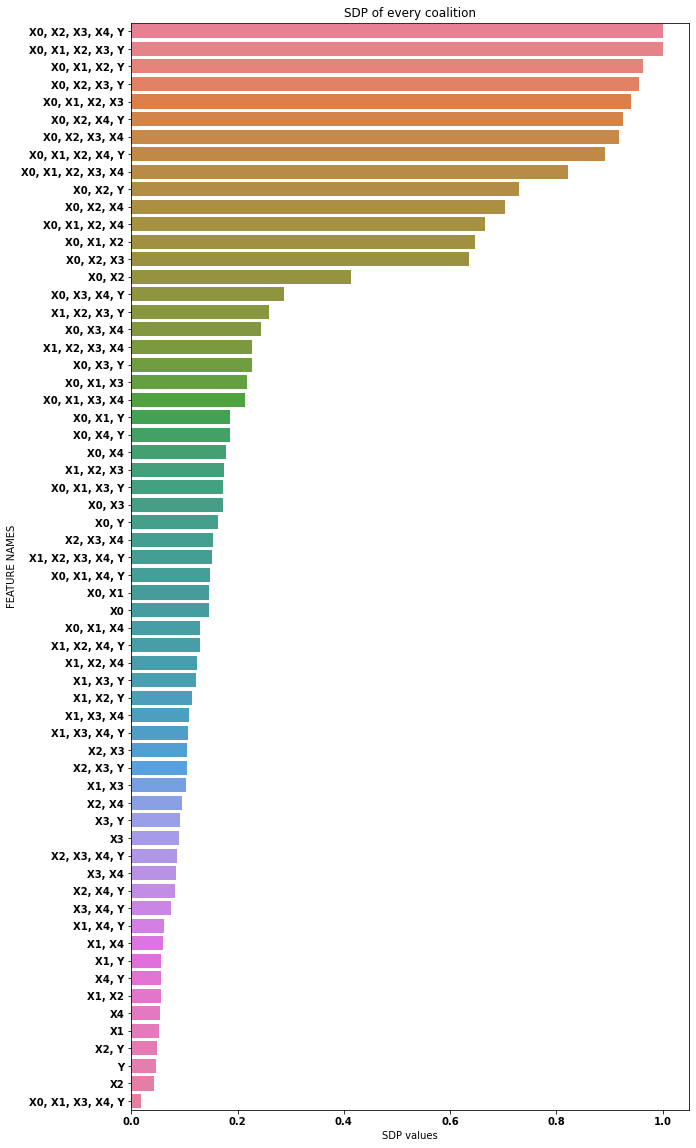

In [25]:
plot_feature_importance(values, names, 'forest_SDP  ', 'SDP values')

In [26]:
# plt.rcParams["font.weight"] = "bold"

def plot_feature_importance(importance, names, model_type, xlabel='SHAP values', title=''):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    seaborn_colors = sns.color_palette("tab10")
    colors = {names[i]: seaborn_colors[i] for i in range(len(names))}

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(dpi=100)
    #Plot Searborn bar chart
    sns.set(font_scale=1.5)
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette=colors)
    #Add chart labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('FEATURE NAMES')

### Compute Classic Shapley values (by taking the coalition of modalities of Y)

In [27]:
C = [[5, 6]] # indice of the modalities of Y

t1_start = time.perf_counter()
forest_sh = acvtree.shap_values(x=np.expand_dims(ind, 0), C=C)
t1_stop = time.perf_counter()

print('SV = {}'.format(forest_sh))
print("Elapsed time:", t1_stop - t1_start)  

100%|██████████| 3192/3192 [01:12<00:00, 43.97it/s] 

SV = [[[11.98569175]
  [ 5.83338805]
  [-3.35371252]
  [15.27028137]
  [ 3.03498277]
  [-0.3556315 ]
  [-0.3556315 ]]]
Elapsed time: 72.60440532799998


In [28]:
forest_shf = np.mean(forest_sh, 0)[:, 0]

<Figure size 1800x1200 with 0 Axes>

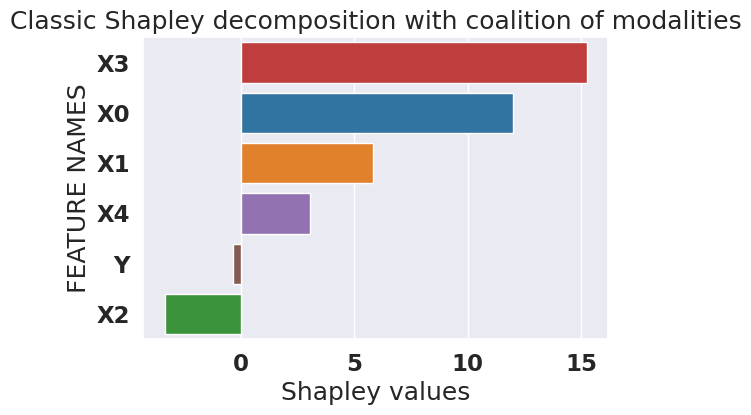

In [29]:
forest_shf = np.mean(forest_sh, 0)[:, 0]
columns_names = ['X0', 'X1', 'X2', 'X3', 'X4', 'Y']
forest_shf = forest_shf[:-1]

plt.figure(dpi=300)
plot_feature_importance(forest_shf, columns_names, 'Normal Shap values ', 'Shapley values', title='Classic Shapley decomposition with coalition of modalities')

### Now, let find the $S^\star$

Cluster find by SDP = [[0, 1, 2, 5, 6], [3, 4]]
Elapsed time: 27.09417814299991


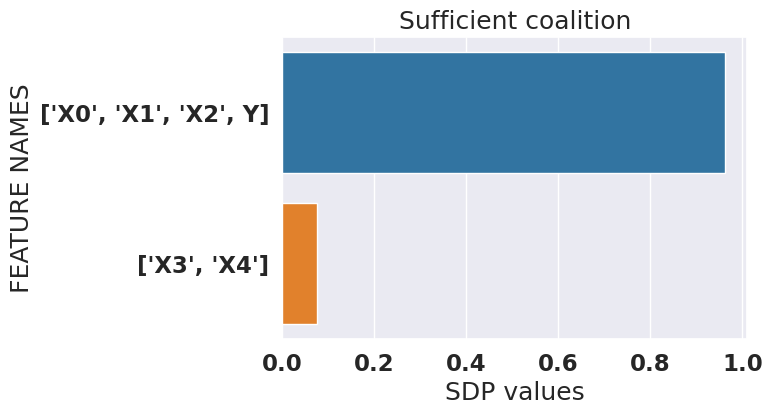

In [30]:
d = 7
final_coal = []
decay = 0.77
threshold = 9
proba = 0.9
index = list(range(d)) 
algo = 'plugin'
data = exp.data
N = 10000

t1_start = time.perf_counter()
acvtree.compute_local_sdp_reg(x=ind, f=fx, threshold=threshold, proba=proba, 
              index=index, data=data, final_coal=final_coal, decay=decay, verbose=0, C=[[5, 6]])

t1_stop = time.perf_counter()

print('Cluster find by SDP = {}'.format(final_coal))
print("Elapsed time:", t1_stop - t1_start)  

sdp_importance = []
for c in final_coal:
    value = acvtree.compute_sdp_reg(ind, fx, threshold, S=chain_l(c), data=data)

    sdp_importance.append(np.mean(value))

sdp_importance

sdp_importance_name = []
for c in final_coal:
    sdp_importance_name.append(str(["X{}".format(i) for i in c]).replace("'X5', 'X6'", 'Y' ))

plot_feature_importance(sdp_importance, sdp_importance_name, model_type='forest SDP  ', xlabel='SDP values', title='Sufficient coalition')

### Since we know that the $S^\star$ is $X_0, X_1, X_2, Y$, we compute the SV based on Sufficient coalition

In [31]:
C = [[5, 6]]
N_star = [3, 4]
S_star = [0, 1, 2, 5, 6]
forest_sh_acv = acvtree.shap_values_acv(x=np.expand_dims(ind, 0), C=C, N_star=N_star,
                        S_star=S_star)[:, :, 0]

100%|██████████| 3192/3192 [00:17<00:00, 184.99it/s]


<Figure size 1800x1200 with 0 Axes>

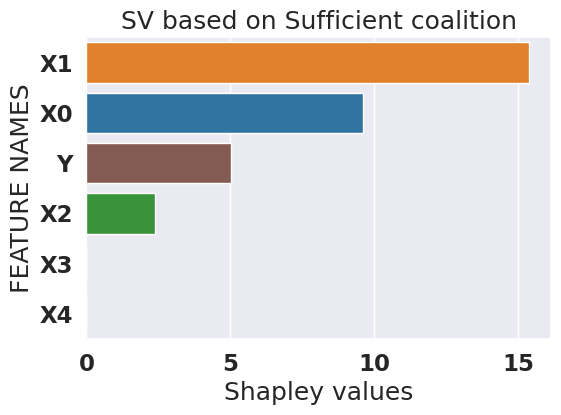

In [32]:
forest_shf_acv = np.mean(forest_sh_acv, 0)
columns_names = ['X0', 'X1', 'X2', 'X3', 'X4', 'Y']
forest_shf_acv = forest_shf_acv[:-1]

plt.figure(dpi=300)
plot_feature_importance(forest_shf_acv, columns_names, 'shap value based on SDP Coalition ', 'Shapley values', title='SV based on Sufficient coalition')